<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 1)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: Single Nucleotide as a Token
   - Treat each base (A, T, C, G) as a single token.
   - Encode each base numerically (e.g., A=0, T=1, C=2, G=3).
   - Train a model on the sequence of encoded bases.

3. **Pros**:
   - Simple and straightforward.
   - Preserves the positional information of each base.

4. **Cons**:
   - Limited contextual information.
   - May not capture long-range dependencies well.

5. **Step**:
   - This approach can be effective for simpler classification tasks or when the sequences are short.
   - We will try models like Recurrent Neural Networks (RNNs) or Convolutional Neural Networks (CNNs) that can capture sequence information.
     
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [95]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

import matplotlib.pyplot as plt
from Utils.VISU import VISU

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [72]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing

* Let split our dataset in training and testset

In [73]:
X = np.array(dataset['sequence'])
y = np.array(dataset['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (342,)
X_test: (38,)
y_train: (342,)
y_test: (38,)


**Note**: We do stratify split to have same proportion of each class in our trainset as well as in our testset

* Let encode our sequence into nunmerical format(tokenization)

In [74]:
def encode_sequence(seq):
    mapping = {'A': 1, 'T': 2, 'C': 3, 'G': 4}
    return [mapping[base] for base in seq]

In [75]:
for i, seq in enumerate(X_train):
    X_train[i] = encode_sequence(seq)
for i, seq in enumerate(X_test):
    X_test[i] = encode_sequence(seq)

In [76]:
print('Length of first and fifth sequence before padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth sequence before padding 1896 1482


* Let pad our sequence so they all have same size

In [77]:
# What is the best strategy to use. Do we have to pad untill we rich the max, or min, or median?

max_seq_length = int(dataset['sequence'].apply(lambda x: len(x)).quantile(0.50))
max_seq_length

1947

In [78]:
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
X_test  = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 1947 1947


* Utils

In [79]:
SEQ_LENGTH = max_seq_length
NUM_CLASS  = 1

In [80]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/A1/Weights/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Model training and testing

**Note**: In the first approach where each base is considered as a single token, using the following model might not be the most suitable choice.
- KNN(KNN is a simple and intuitive algorithm but may not perform well with high-dimensional data, as it relies on distance metrics)
- Decision Tree(Decision Trees can handle both numerical and categorical data well and are interpretable. However, they may overfit the training data, especially with a high-dimensional feature space)

To capture long dependencies we will try Neural Network, CNN, LSTM, ...

#### 4.1 MODEL 1 : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

In [81]:
name="DNA_SNT_FEEDFORWARD1"
def feedforward_net1(name=name, num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=40, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_FEEDFORWARD1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 250)            │       487,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 487,251 (1.86 MB)

 Trainable params: 487,251 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4825 - loss: 8.3044 - val_accuracy: 0.5714 - val_loss: 0.6822
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4671 - loss: 3.0160 - val_accuracy: 0.6857 - val_loss: 0.5948
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5993 - loss: 1.3125 - val_accuracy: 0.6857 - val_loss: 1.1120
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5848 - loss: 1.1851 - val_accuracy: 0.4000 - val_loss: 1.0875
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5507 - loss: 0.8580 - val_accuracy: 0.6857 - val_loss: 0.7865
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6282 - loss: 0.9060 - val_accuracy: 0.4857 - val_loss: 0.9044
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6299 - loss: 0.7122 - val_accuracy: 0.7429 - val_loss: 0.5951
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6751 - loss: 0.7246 - val_accuracy: 0.6571 - val_loss: 0.6454
Epoch 9

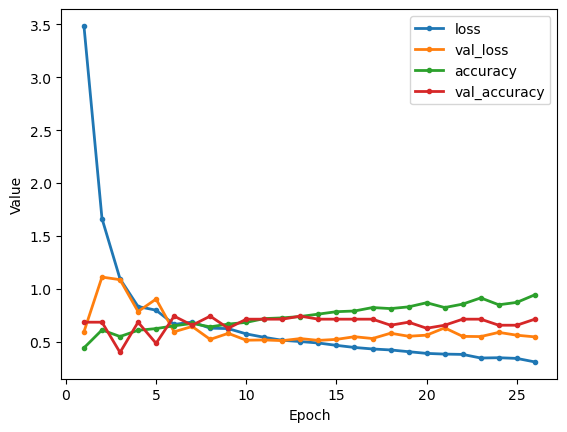

In [82]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.1 MODEL 1-1 : FEED-FORWARD NETWORKS WITH EMBEDDINGS

In [83]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_FEEDFORWARD2"
def feedforward_net2(name=name, num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net2()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=10, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_FEEDFORWARD2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 97350)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 250)            │    24,337,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,338,251 (92.84 MB)

 Trainable params: 24,338,251 (92.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.4270 - loss: 1.0989 - val_accuracy: 0.4203 - val_loss: 0.7300
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7548 - loss: 0.5245 - val_accuracy: 0.5942 - val_loss: 0.6410
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9559 - loss: 0.1655 - val_accuracy: 0.7681 - val_loss: 0.5143
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.7536 - val_loss: 0.5885
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7536 - val_loss: 0.5942
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7536 - val_loss: 0.6324
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7536 - val_loss: 0.6455
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 8.6087e-04 - val_accuracy: 0.7536

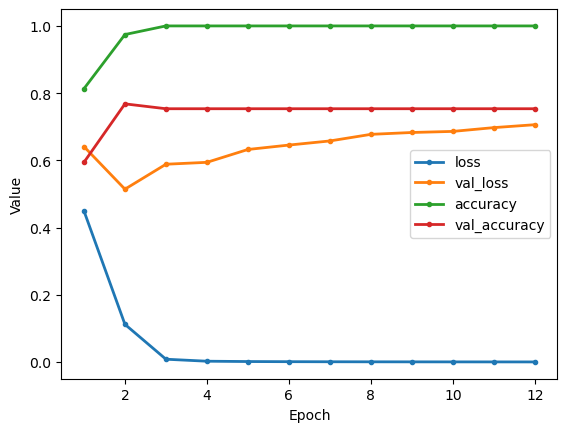

In [84]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.2 MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)
DNA sequence can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions.

In [118]:
embedding_dim   = 200
vocabulary_size = 4+1
name="DNA_SNT_CNN"
def cnn(name=name, layers=2, filters=[32, 64, 128], num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))

    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Dropout(0.1))

    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_output, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn(layers=2)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ (None, 1947, 200)      │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 1945, 32)       │        19,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 1944, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 1942, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 1941, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1941, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1941, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_28     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,761 (104.54 KB)

 Trainable params: 26,633 (104.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6408 - loss: 0.6542 - val_accuracy: 0.5797 - val_loss: 0.6718
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6984 - loss: 0.5936 - val_accuracy: 0.5797 - val_loss: 0.6673
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7543 - loss: 0.5668 - val_accuracy: 0.5797 - val_loss: 0.6591
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.7276 - loss: 0.5567 - val_accuracy: 0.5797 - val_loss: 0.6562
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7576 - loss: 0.5482 - val_accuracy: 0.5797 - val_loss: 0.6527
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7319 - loss: 0.5485 - val_accuracy: 0.5797 - val_loss: 0.6494
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7670 - loss: 0.5349 - val_accuracy: 0.5797 - val_loss: 0.6486
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7528 - loss: 0.5519 - val_accuracy: 0.5797 - val_loss:

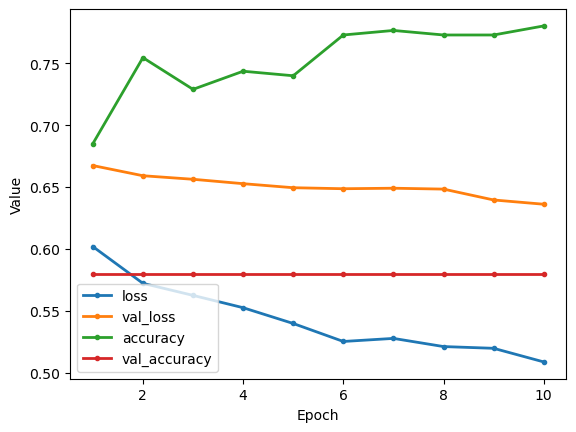

In [119]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.3 MODEL 3 : Simple RNN
At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

In [ ]:

def cnn(name=name, layers=2, filters=[32, 64, 128], num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))

    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Dropout(0.1))

    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_output, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


In [130]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_RNN"
def rnn(name=name, num_class=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(SimpleRNN(200))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    model.add(Dense(num_class, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = rnn()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,651 (197.86 KB)

 Trainable params: 50,651 (197.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4816 - loss: 0.7047 - val_accuracy: 0.5507 - val_loss: 0.6875
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5111 - loss: 0.7202 - val_accuracy: 0.4348 - val_loss: 0.7139
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4793 - loss: 0.7045 - val_accuracy: 0.4783 - val_loss: 0.6881
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5273 - loss: 0.6908 - val_accuracy: 0.5072 - val_loss: 0.6921
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5136 - loss: 0.6990 - val_accuracy: 0.5507 - val_loss: 0.7075
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5094 - loss: 0.7009 - val_accuracy: 0.5942 - val_loss: 0.6817
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5177 - loss: 0.6919 - val_accuracy: 0.5652 - val_loss: 0.6901
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5058 - loss: 0.6984 - val_accuracy: 0.5797 - val_loss: 0.6788
Epoch 9/30
5/5 ━

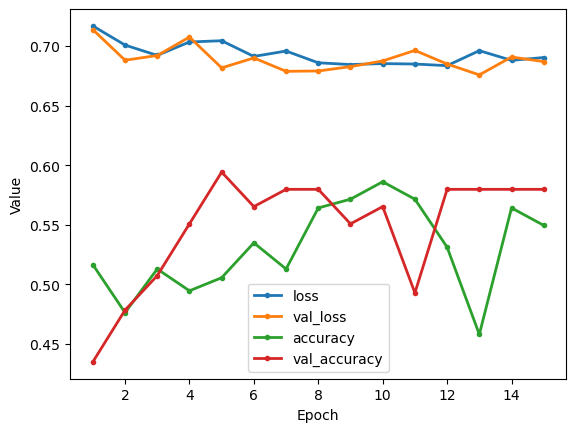

In [131]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.4 MODEL 4 : LSTM
Now, let's use an LSTM model to do classification! To make it a fair comparison to the SimpleRNN, let's start with the same architecture hyper-parameters (e.g., number of hidden nodes, epochs, and batch size). Then, let's experiment with increasing the number of nodes, stacking multiple layers, applying dropouts etc.

In [132]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_LSTM"
def sltm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(LSTM(200))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = sltm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_45 (Embedding)        │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       200,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,251 (786.14 KB)

 Trainable params: 201,251 (786.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5754 - loss: 0.6901 - val_accuracy: 0.5797 - val_loss: 0.6826
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5818 - loss: 0.6836 - val_accuracy: 0.5797 - val_loss: 0.6815
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5668 - loss: 0.6843 - val_accuracy: 0.5797 - val_loss: 0.6805
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5746 - loss: 0.6797 - val_accuracy: 0.5797 - val_loss: 0.6801
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5635 - loss: 0.6844 - val_accuracy: 0.5797 - val_loss: 0.6787
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5742 - loss: 0.6795 - val_accuracy: 0.5797 - val_loss: 0.6774
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5650 - loss: 0.6811 - val_accuracy: 0.5797 - val_loss: 0.6765
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5795 - loss: 0.6793 - val_accuracy: 0.6087 - val_loss: 0.6703
Epoch 9/

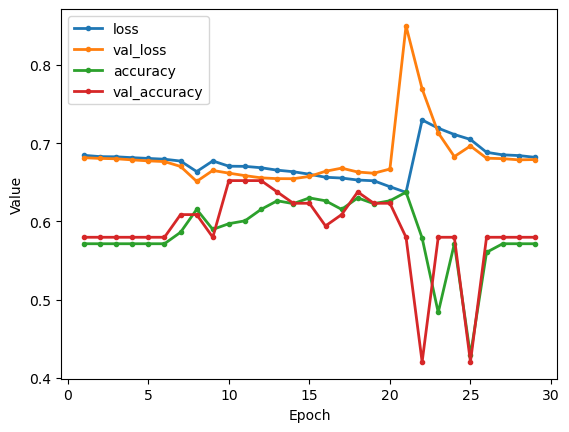

In [133]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.4 MODEL 5 : CNN + LSTM
CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We apply an LSTM over the features learned by the CNN (after a maxpooling layer). This leverages the power of CNNs and LSTMs combined! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize 1 and 0 classes. This learned spatial features may then be learned as sequences by an LSTM layer, and the final classification can be made via a feed-forward connection to a single node.

In [134]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_CNNL_STM1"
def cnn_lstm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(500))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn_lstm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "DNA_SNT_CNNL_STM1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 1947, 32)       │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 973, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500)            │     1,066,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,583 (4.09 MB)

 Trainable params: 1,071,583 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5870 - loss: 0.6964 - val_accuracy: 0.5797 - val_loss: 0.6839
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.5514 - loss: 0.6907 - val_accuracy: 0.5797 - val_loss: 0.6895
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5805 - loss: 0.6892 - val_accuracy: 0.5797 - val_loss: 0.6866
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5672 - loss: 0.6875 - val_accuracy: 0.5797 - val_loss: 0.6836
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6191 - loss: 0.6809 - val_accuracy: 0.5797 - val_loss: 0.6812
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5954 - loss: 0.6779 - val_accuracy: 0.5797 - val_loss: 0.6825
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5603 - loss: 0.6859 - val_accuracy: 0.5797 - val_loss: 0.6821
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5659 - loss: 0.6834 - val_accuracy: 0.5797 - val_loss: 0.6802
Epoch 9/

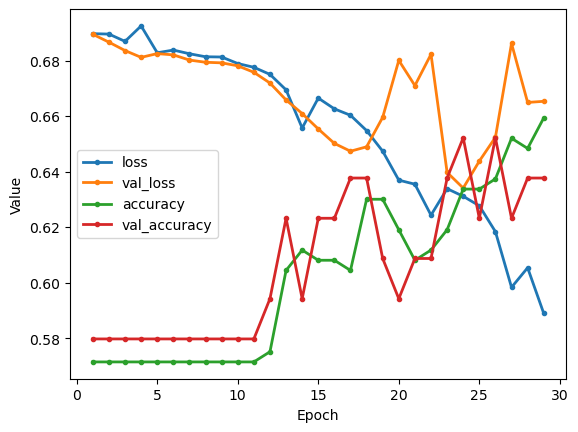

In [135]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])